In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create 3D Surface
from matplotlib import projections
from mpl_toolkits.mplot3d import Axes3D

In [30]:
#loss_df = pd.read_csv("reports/CodeT5_300_15/ts_logs.csv")
#loss_df['roll'] = list(loss_df.rouge.rolling(30).median()) 
#loss_df[['rouge', 'roll']].plot()

COLUMN_BATCH = "gradual_batch"

df = pd.read_csv(f'reports/{COLUMN_BATCH}/nd_infer/results.csv')

In [31]:
BATCH_TEST = 35

loss_df = df.loc[df[COLUMN_BATCH]>BATCH_TEST, :]

BATCH_LIST = sorted(loss_df[COLUMN_BATCH].unique())

In [32]:
loss_df["rouge"] = df[f"{COLUMN_BATCH}_prediction_nd_rouge"]

/tmp/ipykernel_85393/1188466267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df["rouge"] = df[f"{COLUMN_BATCH}_prediction_nd_rouge"]


In [38]:
AC_PERF = 0.1
# Create Confusion Matrix

# Benefit of correct prediction
B = 50
# Costs of wrong prediction = Costs of no prediction
C = 50 

# Min Viable Profit
MIN_ROI = 3000

# Costs of Training - Costs of Continual Learning 
C_Training_300 = 0


In [39]:
def compute_profit(B, C, loss_df, C_Training_300=0, MIN_ROI=3000, AC_PERF = 0.3): 
    loss_df.loc[:,'acceptable_rouge'] = (loss_df["rouge"]>=AC_PERF).astype(int)

    # Compute Costs
    miss = loss_df['acceptable_rouge'].value_counts().loc[0]
    hits = loss_df['acceptable_rouge'].value_counts().loc[1]

    Profit_ND = hits*B-miss*C-C_Training_300
    return Profit_ND, Profit_ND>MIN_ROI

def profit(row, B, C):
    # Compute Costs
    miss = row['acceptable_rouge'].value_counts().loc[0]
    hits = row['acceptable_rouge'].value_counts().loc[1]
    return hits*B-miss*C

def rolling_profit(B, C, loss_df, C_Training_300=500, MIN_ROI=3000, AC_PERF = 0.3):
    loss_df['acceptable_rouge'] = (loss_df["rouge"]>=AC_PERF).astype(int)
    loss_df['marginal_profit'] = loss_df.apply(lambda row: int(row['acceptable_rouge']==1)*B - int(row['acceptable_rouge']==0)*C, axis=1)
    loss_df["rolling_profit"]  =  loss_df['marginal_profit'].cumsum()
    loss_df["rolling_profit"]  = loss_df["rolling_profit"] - C_Training_300
    return loss_df

In [40]:
dd = loss_df[loss_df[COLUMN_BATCH]==36]
dd.loc[:,'acceptable_rouge'] = (dd["rouge"]>=0.1).astype(int)

/tmp/ipykernel_85393/2294893704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:,'acceptable_rouge'] = (dd["rouge"]>=0.1).astype(int)


In [ ]:
profits = list()
for batch_id in BATCH_LIST:
    print(batch_id)
    profit = compute_profit(B, C, loss_df[loss_df[COLUMN_BATCH]==batch_id], C_Training_300=C_Training_300, MIN_ROI=0, AC_PERF=AC_PERF)
    profits.append(profit)
    print(profit)

In [45]:
profits = [profit_tuple[0] for profit_tuple in profits]

In [55]:
profit_df = pd.DataFrame(data={"batch_id" : BATCH_LIST,  "profits" : np.array(profits)})

<Axes: xlabel='batch_id', ylabel='profits'>

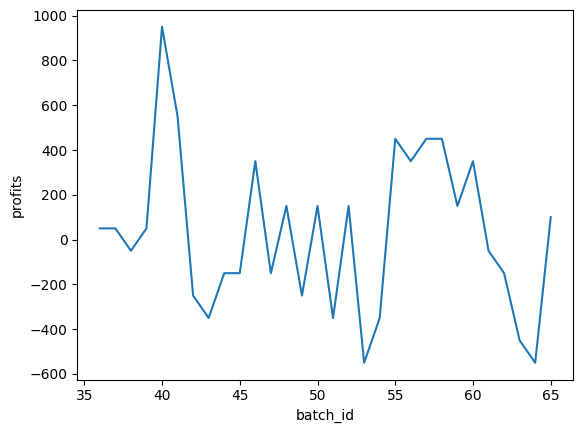

In [56]:
sns.lineplot(data=profit_df, x="batch_id", y="profits", orient="x")

In [5]:
x = np.arange(0, 11800)

In [6]:
profits = pd.DataFrame()
for ctr in range(300, 2000, 100):
    for b in range(1, 100): 
        set_profit = {}
        set_profit['benefit'] = b
        set_profit['training_costs_per_300'] = ctr
        set_profit['profit'] = compute_profit(B=b, C=100-b, loss_df=loss_df, C_Training_300=ctr)[0]
        set_profit = pd.DataFrame(data=set_profit, index=[0])
        profits = pd.concat([profits, set_profit], axis=0)
profits = profits.reset_index(drop=True)

In [7]:
#x_data = np.asarray([2, 2, 2, 3, 3, 3, 1, 1, 1, 4, 4, 4])
#y_data = np.asarray([16, 64, 32, 64, 32, 16, 16, 32, 64, 32, 16, 64])
#z_data = np.asarray([64, 31, 29, 78, 72, 63, 93, 40, 54, 35, 44, 3])
# Sort coordinates and reshape in grid
idx = np.lexsort((profits['benefit'], profits['training_costs_per_300'])).reshape(17, 99)
# Plot

In [47]:
118*100

11800

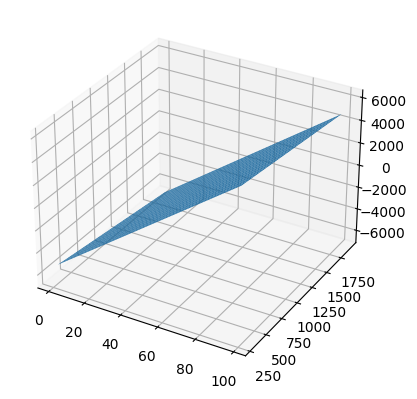

In [9]:
# Plot 3D Surface
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(profits['benefit'].values[idx], profits['training_costs_per_300'].values[idx], profits['profit'].values[idx])
plt.show()

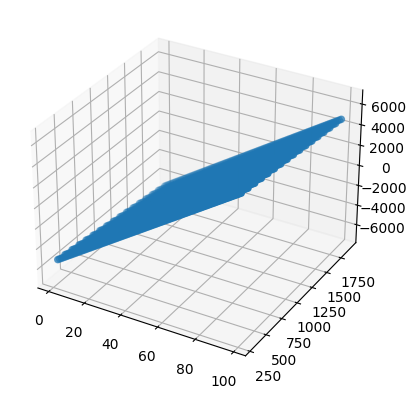

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(profits['benefit'], profits['training_costs_per_300'], profits['profit'])
plt.show()